In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


from tensorflow.keras.applications import VGG19,VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout


2024-04-18 23:10:38.806820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 23:10:38.806933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 23:10:38.937834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir='/kaggle/input/covid19-image-dataset/Covid19-dataset/train'
test_dire='/kaggle/input/covid19-image-dataset/Covid19-dataset/test'

In [3]:
train_dir_co=train_dir+'/Covid'
train_dir_no=train_dir+'/Normal'
train_dir_pe=train_dir+'/Viral Pneumonia'

In [4]:
test_dir_co=test_dire+'/Covid'
test_dir_no=test_dire+'/Normal'
test_dir_pe=test_dire+'/Viral Pneumonia'

In [5]:
y=0
for i in[train_dir_co,train_dir_no,train_dir_pe]:
    print(len(os.listdir(i)))
    print('\n')
    y+=len(os.listdir(i))
        
        
y

111


70


70




251

In [6]:
x=0
for i in[test_dir_co,test_dir_no,test_dir_pe]:
    print(len(os.listdir(i)))
    print('\n')
    x+=len(os.listdir(i))
    
print(x)

26


20


20


66


# train 

In [7]:
def create_class_dataframe(class_dir, class_name):
    files = os.listdir(class_dir)
    image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
    data = {'Image_Path': [os.path.join(class_dir, file) for file in image_files],
            'Class': [class_name] * len(image_files)}
    return pd.DataFrame(data)


In [8]:
df_covied=create_class_dataframe(train_dir_co, '0')
df_no=create_class_dataframe(train_dir_no,'1')
df_pe=create_class_dataframe(train_dir_pe, '2')

df = pd.concat([df_covied, df_no,df_pe], ignore_index=True)

In [9]:
def shuffle_dataframe(df):
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    return shuffled_df

df=shuffle_dataframe(df)

In [10]:
df.head()

,Image_Path,Class
0,/kaggle/input/covid19-image-dataset/Covid19-da...,2
1,/kaggle/input/covid19-image-dataset/Covid19-da...,0
2,/kaggle/input/covid19-image-dataset/Covid19-da...,2
3,/kaggle/input/covid19-image-dataset/Covid19-da...,2
4,/kaggle/input/covid19-image-dataset/Covid19-da...,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  251 non-null    object
 1   Class       251 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [12]:
df['Image_Path'].values[0]

'/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Viral Pneumonia/043.jpeg'

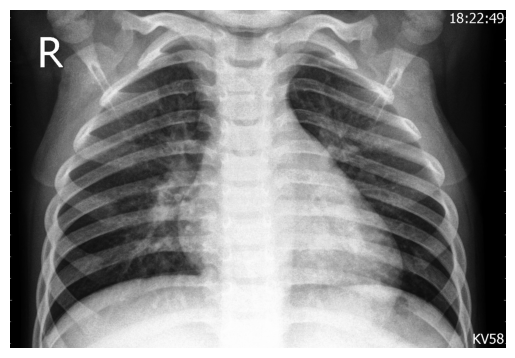

In [13]:
#img=cv2.imread(df['Image_Path'].values[0])
img = mpimg.imread(df['Image_Path'].values[0])

plt.imshow(img)
plt.axis('off')  
plt.show()



In [14]:
img.shape

(976, 1432, 3)

In [15]:
df['Class'].values[0]

'2'

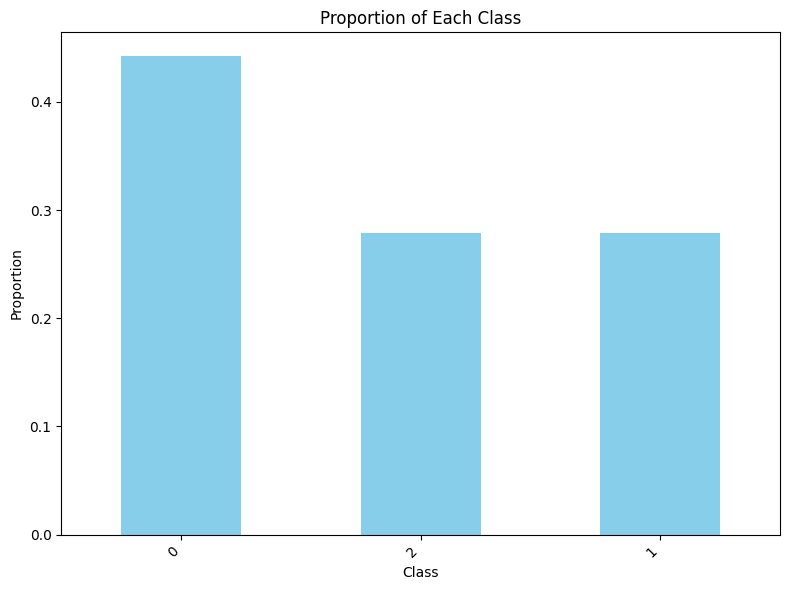

In [16]:

def visualize_class_proportions(labels):
    # Count the occurrences of each class label
    class_counts = labels.value_counts()
    
    # Calculate proportions
    class_proportions = class_counts / class_counts.sum()
    
    # Plotting
    plt.figure(figsize=(8, 6))
    class_proportions.plot(kind='bar', color='skyblue')
    plt.title('Proportion of Each Class')
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'labels' is a Pandas Series containing class labels
visualize_class_proportions(df['Class'])


In [17]:

def print_class_proportions(labels):
    # Count the occurrences of each class label
    class_counts = labels.value_counts()
    
    # Calculate proportions
    total_samples = len(labels)
    class_proportions = class_counts / total_samples
    
    # Print class proportions
    print("Class Proportions:")
    for class_label, proportion in class_proportions.items():
        print(f"Class {class_label}: {proportion:.2%}")

# Example usage:
# Assuming 'labels' is a Pandas Series containing class 

print_class_proportions(df['Class'])


Class Proportions:
Class 0: 44.22%
Class 2: 27.89%
Class 1: 27.89%


# Test

In [18]:
df_test_covied=create_class_dataframe(test_dir_co, '0')
df_test_no=create_class_dataframe(test_dir_no,'1')
df_test_pe=create_class_dataframe(test_dir_pe, '2')

df_test = pd.concat([df_test_covied, df_test_no,df_test_pe], ignore_index=True)
df_test=shuffle_dataframe(df_test)
df_test.shape

(66, 2)

In [19]:
df_test.head()

,Image_Path,Class
0,/kaggle/input/covid19-image-dataset/Covid19-da...,0
1,/kaggle/input/covid19-image-dataset/Covid19-da...,0
2,/kaggle/input/covid19-image-dataset/Covid19-da...,2
3,/kaggle/input/covid19-image-dataset/Covid19-da...,1
4,/kaggle/input/covid19-image-dataset/Covid19-da...,1


In [20]:
df_test['Image_Path'].values[0]

'/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg'

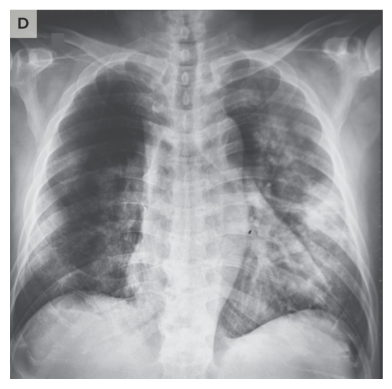

In [21]:
#img=cv2.imread(df['Image_Path'].values[0])
img = mpimg.imread(df_test['Image_Path'].values[0])

plt.imshow(img)
plt.axis('off')  
plt.show()



In [22]:
img.shape

(874, 880, 3)

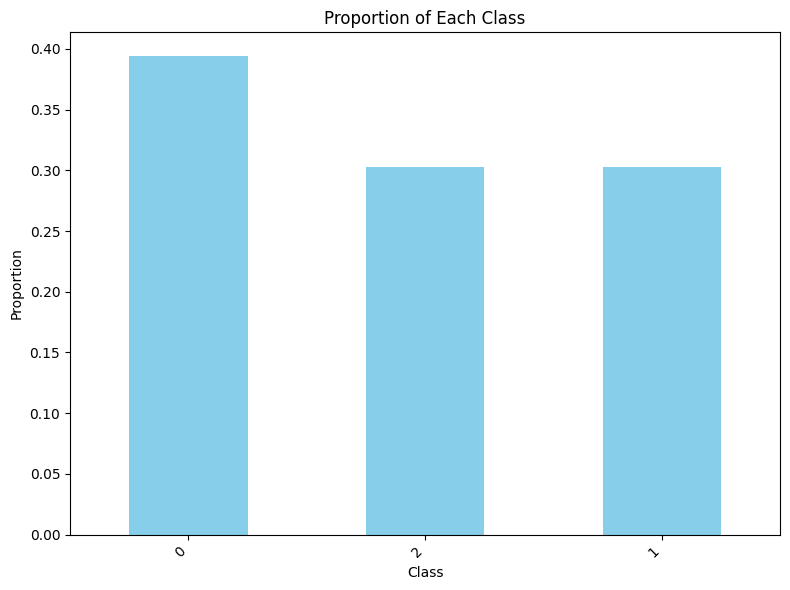

Class Proportions:
Class 0: 39.39%
Class 2: 30.30%
Class 1: 30.30%


In [23]:
visualize_class_proportions(df_test['Class'])
print_class_proportions(df_test['Class'])

# preprocessing test

In [37]:



def preprocess_image(image_path, target_size=(224, 224), grayscale=False):
    
    image = cv2.resize(image_path, target_size)
    
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = image.astype('float32') / 255.0
    
    return image

def load_and_preprocess_images(image_series, label_series):
    images = []
    labels = []

    for img_path, label in zip(image_series, label_series):
        img = cv2.imread(img_path)
        img = preprocess_image(img)
        images.append(img)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels




In [38]:
test_image,test_label=load_and_preprocess_images(df_test['Image_Path'], df_test['Class'])

In [39]:
test_image[0].shape

(224, 224, 3)

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

def evaluate_classification(y_true, y_pred, classes):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    

In [27]:
classes=['0','1','2']
test_label=test_label.astype('int')

# Data Augmentation

In [28]:

# Assuming df is your DataFrame with 'path' and 'label' columns

# Split the DataFrame into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create data generators for training and validation data
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate the image randomly by up to 20 degrees
    shear_range=0.2,  # Shear intensity (shear angle in radians)
    zoom_range=0.1,  # Zoom the image randomly by up to 20%
    horizontal_flip=True,
        vertical_flip=True,# Flip the image horizontally
   # brightness_range=[0.4,0.6],
     #preprocessing_function=load_and_preprocess_images,
     
        rescale=1.0/255,

    
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Class',
   target_size=(224, 224),
    batch_size=64,
     color_mode="rgb",
    class_mode='sparse'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Image_Path',
    y_col='Class',
    target_size=(224, 224),
    batch_size=64,
     color_mode="rgb",
    class_mode='sparse'
)

# Fit the model using the training data generator


Found 200 validated image filenames belonging to 3 classes.
Found 51 validated image filenames belonging to 3 classes.


# models

In [29]:
batch_size=64
epochs=40

In [30]:
import tensorflow as tf
import keras_cv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check and set GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Your original code




In [31]:
input_shape=(224,224,3)

In [ ]:

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
      #  Dropout(.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        # Dropout(.2),


        Flatten(),
        Dense(256, activation='relu'),
        # Dropout(.2),
         #Dense(64, activation='relu'), 
         #Dropout(.2),
       # Dense(128, activation='relu'),
      #Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Example usage:
# img_width, img_height = 150, 150  # Example image dimensions
# num_classes = 10  # Example number of classes
# input_shape = (img_width, img_height, 3)  # Assuming RGB images
# model = create_cnn_model(input_shape, num_classes)
# model.summary()


In [ ]:
model=create_cnn_model((224,224,3),3)
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples //batch_size)
         #,callbacks=[early_stopping])

# Optionally, you can plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

In [ ]:
#model.save("./kaggle/input/model.h5")
#print("Saved model to disk")

In [ ]:
model.summary()

In [ ]:
loss,acc=model.evaluate(test_image,test_label)
loss,acc

In [ ]:

predicted_labels=model.predict(test_image)
predicted_label=np.argmax(predicted_labels,axis=1)
evaluate_classification(test_label, predicted_label, classes)


In [ ]:
predicted_label

# vgg16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713481957.175892      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713481957.196951      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/3 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3889 - loss: 1.3131 

W0000 00:00:1713481967.850729      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3745 - loss: 1.5150  

W0000 00:00:1713482022.825418      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 134s 33s/step - accuracy: 0.3672 - loss: 1.6160 - val_accuracy: 0.4118 - val_loss: 1.1812
Epoch 2/40
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.3125 - loss: 1.1139

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 854ms/step - accuracy: 0.3125 - loss: 1.1139 - val_accuracy: 0.4118 - val_loss: 1.4529
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5995 - loss: 1.1503 - val_accuracy: 0.6275 - val_loss: 0.9602
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 808ms/step - accuracy: 0.5781 - loss: 0.9090 - val_accuracy: 0.7647 - val_loss: 0.7020
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7578 - loss: 0.7303 - val_accuracy: 0.6078 - val_loss: 0.8276
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 880ms/step - accuracy: 0.7031 - loss: 0.8248 - val_accuracy: 0.7647 - val_loss: 0.5504
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8527 - loss: 0.3163 - val_accuracy: 0.8431 - val_loss: 0.5930
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 882ms/step - accuracy: 0.9375 - loss: 0.2911 - val_accuracy: 0.8235 - val_loss: 0.6092
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7933 - loss: 0.4300 - val_accuracy: 0.8235 - val_loss: 0.5875
Epoch 10/40
3/3

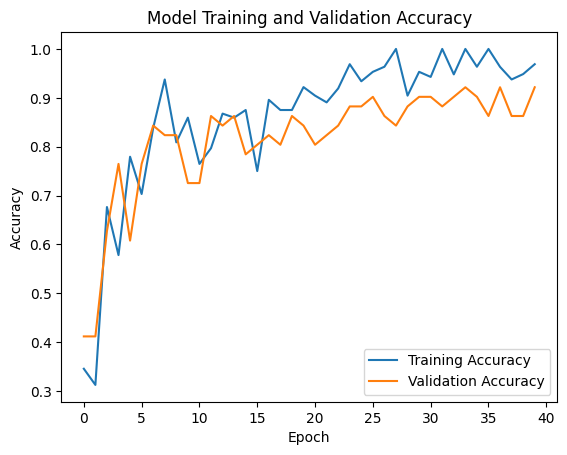

In [32]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(128, activation='leaky_relu')(x)
#x = Dropout(.2)(x)

x = Dense(64, activation='relu')(x)
#x = Dropout(.2)(x)

#x = Dense(128, activation='relu')(x)
#x = Dropout(.2)(x)

#x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

predictions = Dense(3, activation='softmax')(x)
# Create final model
model_16 = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model_16.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_16.fit(train_generator, 
                       steps_per_epoch=train_generator.samples // batch_size,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=valid_generator,
                      validation_steps=valid_generator.samples //batch_size)
                     #  ,callbacks=[early_stopping])
# Plot training and validation accuracies
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.legend()
plt.show()


In [33]:
model_16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,374,219 (92.98 MB)

 Trainable params: 3,219,843 (12.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 6,439,688 (24.57 MB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


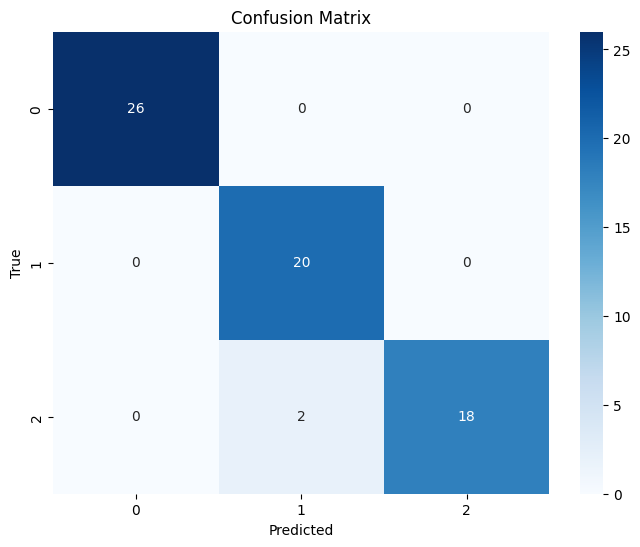

Accuracy: 0.9696969696969697
Precision: [1.         0.90909091 1.        ]
Recall: [1.  1.  0.9]
F1-score: [1.         0.95238095 0.94736842]


In [44]:
prediction=model_16.predict(test_image)
prediction=np.argmax(prediction,axis=1)
evaluate_classification(test_label.astype('int'), prediction, classes)

In [41]:
prediction

array([0, 0, 2, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1,
       0, 2, 1, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 0, 2])

In [43]:
test_label.astype('int')

array([0, 0, 2, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1,
       0, 2, 1, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 0, 2, 0, 2])

In [46]:
loss,acc=model_16.evaluate(test_image,test_label.astype('int'))
loss,acc

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step - accuracy: 1.0000 - loss: 0.0487

W0000 00:00:1713482564.183915      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.9770 - loss: 0.1102


(0.14257501065731049, 0.9696969985961914)

In [135]:
model_16.save('vgg16_model_covied_v3.h5')